In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping


2025-07-22 14:34:26.203412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 14:34:26.310144: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 14:34:26.412168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753175066.503199    9370 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753175066.527990    9370 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753175066.703103    9370 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
data_dir = "../data"
categories = os.listdir(data_dir)
img_size = 150

data = []

for category in tqdm(categories):
    folder = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(folder):
        try:
            img_path = os.path.join(folder, file)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_size, img_size))
            img = np.array(img) / 255.0
            data.append((img, label))
        except:
            continue

X, y = zip(*data)
X = np.array(X)
y = np.array(y)


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.55s/it]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [4]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [5]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


In [6]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/tmp/ipykernel_9370/453824511.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
2025-07-22 14:35:09.738970: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop]
)


/home/aman/brain_tumor_project/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.6030 - loss: 1.0446

2025-07-22 14:35:46.374766: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 91530000 exceeds 10% of free system memory.


43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 817ms/step - accuracy: 0.6056 - loss: 1.0376 - val_accuracy: 0.7906 - val_loss: 0.5489
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 728ms/step - accuracy: 0.8432 - loss: 0.4409 - val_accuracy: 0.8407 - val_loss: 0.4287
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 727ms/step - accuracy: 0.8619 - loss: 0.3739 - val_accuracy: 0.8289 - val_loss: 0.4549
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 738ms/step - accuracy: 0.9049 - loss: 0.2860 - val_accuracy: 0.8673 - val_loss: 0.3938
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 732ms/step - accuracy: 0.9098 - loss: 0.2482 - val_accuracy: 0.8378 - val_loss: 0.4982
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 733ms/step - accuracy: 0.8907 - loss: 0.2754 - val_accuracy: 0.8378 - val_loss: 0.5433
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 738ms/step - accuracy: 0.9046 - loss: 0.2744 - val_accuracy: 0.8142 - val_loss: 0.5582
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 833ms/step - accuracy: 0.8925 - loss: 0.2604 - val_accuracy: 0.855

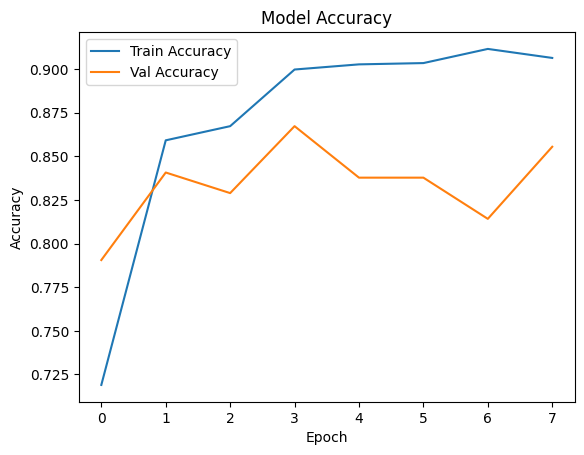

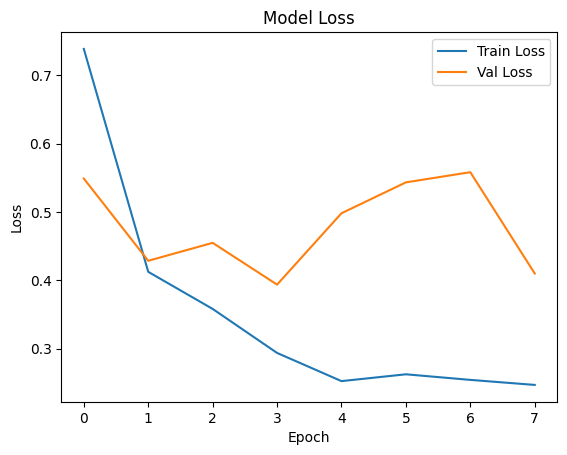

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


2025-07-22 14:48:04.281620: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 91530000 exceeds 10% of free system memory.


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 682ms/step
Classification Report:
              precision    recall  f1-score   support

  meningioma       0.79      0.68      0.73        72
      glioma       0.96      0.89      0.93       113
   pituitary       0.82      0.94      0.88        87
    no_tumor       0.86      0.93      0.89        67

    accuracy                           0.87       339
   macro avg       0.86      0.86      0.86       339
weighted avg       0.87      0.87      0.87       339



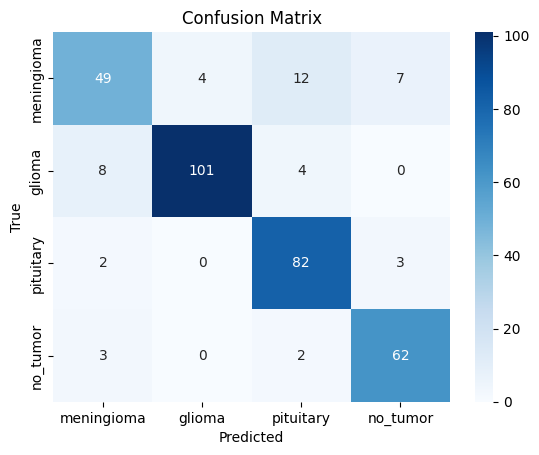

In [10]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Determine actual class labels present in y_test
unique_labels = np.unique(y_test)
target_names = [categories[i] for i in unique_labels]

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, labels=unique_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=unique_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [11]:
model.save('../models/brain_tumor_mobilenet_model_with_unknown.keras')